In [40]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import *
from darts.metrics import *
from darts.dataprocessing.transformers import Scaler
from darts.models.forecasting.catboost_model import CatBoostModel
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv(r'all_features_with_swan.csv')
df.drop(columns=['is_swan_event_covid', 'is_swan_event_default', 'is_swan_event_oil', 'is_swan_event_crimea'], inplace=True)
df.head()

,Отчетная дата,Всего,добыча полезных ископаемых,добыча топливно-энергетических полезных ископаемых,обрабатывающие производства,производство пищевых продуктов,обработка древесины и производство изделий из дерева,целлюлозно-бумажное производство; издательская и полиграфическая деятельность,"производство кокса, нефтепродуктов и ядерных материалов",химическое производство,...,bucks_rate,gdp,gdp_growth,gdp_pps,gdp_usd,gdp_deflator,index_price_mod,index_price_mod_growth,index_price_mod_growth_prev_year,key_rate
0,2009-01-01,346769.0,3084.0,1813.0,69830.0,23171.0,3464.0,1861.0,381.0,2475.0,...,29.3916,38807.2,-7.8,3054.26,1309.17,102.0,113.4,102.4,0.0,13.0
1,2009-02-01,346769.0,3084.0,1813.0,69830.0,23171.0,3464.0,1861.0,381.0,2475.0,...,29.3916,38807.2,-7.8,3054.26,1309.17,102.0,0.0,101.7,104.1,13.0
2,2009-03-01,346769.0,3084.0,1813.0,69830.0,23171.0,3464.0,1861.0,381.0,2475.0,...,29.3916,38807.2,-7.8,3054.26,1309.17,102.0,0.0,101.3,105.4,13.0
3,2009-04-01,346769.0,3084.0,1813.0,69830.0,23171.0,3464.0,1861.0,381.0,2475.0,...,33.9032,38807.2,-7.8,3054.26,1309.17,102.0,0.0,100.7,106.2,13.0
4,2009-05-01,380065.0,4032.0,1871.0,74435.0,24133.0,3711.0,1999.0,672.0,2615.0,...,32.9740,38807.2,-7.8,3054.26,1309.17,102.0,0.0,100.6,106.8,12.5


In [11]:
def covariates(data: pd.DataFrame) -> list:

    true_columns = list(data.columns)
    true_columns.remove('Отчетная дата')
    
    train_data = []
    for column in true_columns:
        ts = TimeSeries.from_dataframe(data[['Отчетная дата', column]], time_col='Отчетная дата', fillna_value=True)
        scaler = Scaler()

        data[column] = np.array(data[column], dtype=np.int64)
        train_data.append(scaler.fit_transform(ts))
        
        if column == 'Всего':
            global main_scaler
            main_scaler = scaler

    
    return train_data

In [13]:
main_data = covariates(df)

train_data, val_data = main_data[0][:-24], main_data[0][-24:]

model_DCTB = CatBoostModel(lags=1)
best_parameters = model_DCTB.gridsearch(
                            parameters={'output_chunk_length': [i for i in range(1, 13)],
                                        'lags': [[-i for i in range(1, j)] for j in range(2, 64)]},
                            series=train_data,
                            val_series=val_data,
                            metric=r2_score,
                            verbose=True,
                            n_jobs=-1)

print(best_parameters)


  0%|          | 0/744 [00:00<?, ?it/s]

(<darts.models.forecasting.catboost_model.CatBoostModel object at 0x000001AA363D4220>, {'output_chunk_length': 1, 'lags': [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38]}, -5.7683123957958555)


In [62]:
from tqdm import tqdm

def gridsearch_param(dataframe, num_lags, output_chunk):
    iter = 0
    best_r2s = -1000

    lags_list = [[-i for i in range(1, j)] for j in range(2, num_lags + 1)]
    for chunk in tqdm(range(1, output_chunk + 1)):
        for lag in lags_list:
            tmp_model = CatBoostModel(lags=lag,
                                      output_chunk_length=chunk)
            
            main_data = covariates(dataframe)
            train_data, val_data = main_data[0][:-24], main_data[0][-24:]

            tmp_model.fit(series=main_data, verbose=False)

            pred_data = tmp_model.predict(series=train_data, n=24)
            pred_data = main_scaler.inverse_transform(pred_data)
            val_data = main_scaler.inverse_transform(val_data)

            r2s = r2_score(val_data, pred_data)

            if r2s > best_r2s:
                best_r2s == r2s
                better_param = (chunk, lag)

    
            iter += 1
            print(f'Calculate model #{iter} done!')
    
    return best_r2s, better_param

In [63]:
gridsearch_param(df, 64, 13)

  0%|          | 0/13 [00:00<?, ?it/s]

Calculate model #1 done!
Calculate model #2 done!
Calculate model #3 done!
Calculate model #4 done!
Calculate model #5 done!
Calculate model #6 done!
Calculate model #7 done!
Calculate model #8 done!
Calculate model #9 done!
Calculate model #10 done!
Calculate model #11 done!
Calculate model #12 done!
Calculate model #13 done!
Calculate model #14 done!
Calculate model #15 done!
Calculate model #16 done!
Calculate model #17 done!
Calculate model #18 done!
Calculate model #19 done!
Calculate model #20 done!
Calculate model #21 done!
Calculate model #22 done!
Calculate model #23 done!
Calculate model #24 done!
Calculate model #25 done!
Calculate model #26 done!
Calculate model #27 done!
Calculate model #28 done!
Calculate model #29 done!
Calculate model #30 done!
Calculate model #31 done!
Calculate model #32 done!
Calculate model #33 done!


C:\Users\Goldian\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Goldian\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


4
61
['__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_base_calc_leaf_indexes', '_base_drop_unused_features', '_base_eval_metrics', '_base_predict', '_base_shrink', '_base_virtual_ensembles_predict', '_calc_fstr', '_calc_leaf_indexes', '_calc_ostr', '_check_is_compatible_loss', '_convert_to_asymmetric_representation', '_dataset_train_eval_split', '_deserialize_model', '_estimator_type', '_eval_metrics', '_fit', '_get_borders', '_get_cat_feature_indices', '_get_default_prediction_type', '_get_embedding_feature_indices', '_get_float_feature_indices', '_get_nan_treatments', '_get_params', '_get_tags', '_get_text_feature_indices', '_get_tr

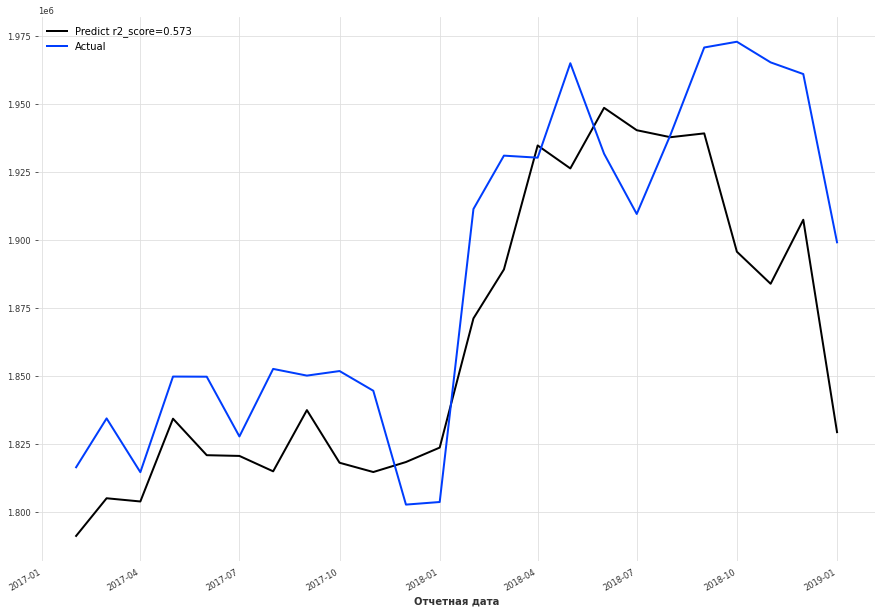

In [59]:
main_data = covariates(df)

train_data, val_data = main_data[0][:-24], main_data[0][-24:]

best_model = CatBoostModel(lags=best_parameters[1]['lags'],
                           output_chunk_length=best_parameters[1]['output_chunk_length'])

best_model = CatBoostModel(lags=[-i for i in range(3, 64)],
                           output_chunk_length = 4,
                           )

best_model.fit(series=main_data)
pred_data = best_model.predict(series=train_data, n=24)

pred_data = main_scaler.inverse_transform(pred_data)
val_data = main_scaler.inverse_transform(val_data)

plt.figure(figsize=(15, 10))
plt.title(f'r2_score: {r2_score(val_data, pred_data)}')
pred_data.plot(label=f'Predict r2_score={round(r2_score(val_data, pred_data), 3)}')
val_data.plot(label='Actual')
plt.savefig('beda.png')

print(r2_score(val_data, pred_data))

0.5733402192791436


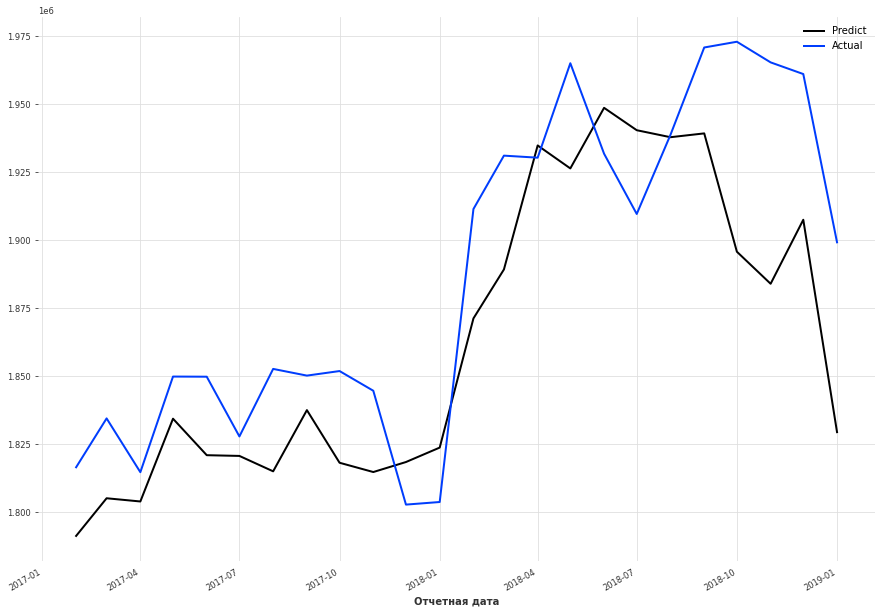

In [57]:
plt.figure(figsize=(15, 10))
plt.title(f'r2_score: {r2_score(val_data, pred_data)}')
pred_data.plot(label=f'Predict r2_score={round(r2_score(val_data, pred_data), 3)}')
val_data.plot(label='Actual')
plt.savefig('beda.png')

In [ ]:
def advanced_gridsearch(num_lags=4, output_chunk=2):
    iter = 0
    lags_list = [[-i for i in range(1, j)] for j in range(2, num_lags + 1)]
    for chunk in range(1, output_chunk + 1):
        for lag in lags_list:
            tmp_model = CatBoostModel(lags=lag,
                                      output_chunk_length=chunk)
            tmp_model.fit(series=main_data, verbose=False)
            tmp_pred = tmp_model.predict(series=main_data[0], n=96)

            tmp_pred = main_scaler.inverse_transform(tmp_pred)

            plt.figure(figsize=(15, 10))
            tmp_pred.plot(label='Our predict')
            plt.savefig(f'graphics/{iter}.png')
            iter += 1
            print(f'Calculate model #{iter} done!')

In [ ]:
advanced_gridsearch(64, 12)